In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix
from sklearn import manifold
import lightgbm as lgb 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# load the dataset
df = pd.read_csv("/Users/mtj/Desktop/credit_card_fraud_data_v2.csv")
df = df.rename(columns={'Time_Stamp':'step', 'Transaction_Type':'type', 'Amount':'amount', 'Client_Id':'nameOrig', 'Client_Old_Balance':'oldBalanceOrig',
'Cleint_New_Balance':'newBalanceOrig', 'Merchant_Id':'nameDest', 'Merchant_Old_Balance':'oldBalanceDest', 'Merchant_New_Balance':'newBalanceDest',
'Is_Fraud':'isFraud', 'Is_Flagged_Fraud':'isFlaggedFraud'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


In [3]:
# Feature engineering
data = df.copy()

# add source and target type
data['OrigC'] = data['nameOrig'].apply(lambda x: 1 if str(x).find('C') == 0 else 0)
data['DestC'] = data['nameDest'].apply(lambda x: 1 if str(x).find('C') == 0 else 0)
data['PURCHASE'] = data['type'].apply(lambda x: 1 if x == 'PURCHASE' else 0)
data['CASH_OUT'] = data['type'].apply(lambda x: 1 if x == 'CASH_OUT' else 0)

# add transaction amount error
data['OrigAmntErr'] = (abs(data.oldBalanceOrig - data.newBalanceOrig) - data.amount) * data['OrigC']
data['DestAmntErr'] = (abs(data.oldBalanceDest - data.oldBalanceDest) - data.amount) * data['DestC']

# modify timestamp
data['step24'] = data.step % 24

In [4]:
# Check series transaction for same client
data_series = data.copy()
data_series = data_series.sort_values(['step'])
print(sum(data_series.groupby('nameOrig')['step'].count()>1))
# The proportion of clients with more than 1 transaction recorded is very small (around 1.5%)
# Thus it is not feasible to fit time series model on each client's transaction data

943967


In [5]:
# drop step, type, nameOrig and nameDest
droplist = ['step','type','nameOrig','nameDest']
data = data.drop(labels = droplist, axis = 1)

In [6]:
# over-sampling
X = data.drop('isFraud', axis = 1)
Y = data.isFraud

ros = RandomOverSampler(random_state=0)
X_resampled, Y_resampled = ros.fit_resample(X, Y)

X_resampled = pd.DataFrame(X_resampled)
Y_resampled = pd.DataFrame(Y_resampled)
data_resample = pd.concat([X_resampled, Y_resampled], axis = 1, join_axes = [X_resampled.index])

In [7]:
# rename over-sampled dataframe columns
data_resample.columns = ['amount','oldBalanceOrig','newBalanceOrig','oldBalanceDest','newBalanceDest','isFlaggedFraud','OrigC','DestC','PURCHASE','CASH_OUT','OrigAmntErr','DestAmntErr','step24','isFraud']
data = data_resample

In [8]:
# data normalization'
norm = ['amount','oldBalanceOrig','newBalanceOrig','oldBalanceDest','newBalanceDest','OrigAmntErr','DestAmntErr','step24']
data[norm] = StandardScaler().fit_transform(data[norm])
data.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFlaggedFraud,OrigC,DestC,PURCHASE,CASH_OUT,OrigAmntErr,DestAmntErr,step24,isFraud
0,-0.432133,-0.382640,-0.165838,-0.402258,-0.43,0.0,1.0,0.0,0.0,0.0,0.148685,0.250460,-2.008302,0
1,-0.435292,-0.424089,-0.226285,-0.402258,-0.43,0.0,1.0,1.0,0.0,0.0,0.148685,0.249395,-2.008302,0
2,-0.435959,-0.429954,-0.234600,-0.402258,-0.43,0.0,1.0,0.0,1.0,0.0,0.148685,0.250460,-2.008302,1
3,-0.435959,-0.429954,-0.234600,-0.396831,-0.43,0.0,1.0,0.0,0.0,1.0,0.148685,0.250460,-2.008302,1
4,-0.431409,-0.418436,-0.221780,-0.402258,-0.43,0.0,1.0,0.0,0.0,0.0,0.148685,0.250460,-2.008302,0


In [9]:
# print result function
def presult(clf,x_test,y_test, plotimp = 1):
    y_prob = clf.predict_proba(x_test)
    y_pred = clf.predict(x_test)
    print ('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print ('F1 - macro :',(f1_score(y_test,y_pred,average = 'macro')))
    print  ('Confusion_matrix : ')
    print (confusion_matrix(y_test,y_pred))
    sns.set(font_scale = 1.5)
    sns.heatmap(confusion_matrix(testY,y_pred), annot = True,annot_kws = {"size": 15},fmt = '10g')
    plt.show()
    if plotimp == 1:
        plot_importance(clf)
        plt.show()

AUPRC : 0.9999999999999999
F1 - macro : 0.49954454704758905
Confusion_matrix : 
[[      0       0]
 [   5783 3171421]]


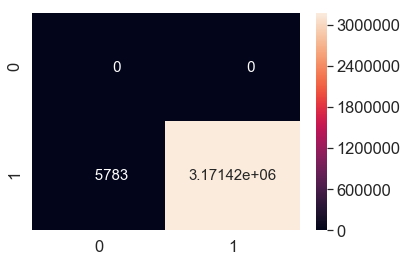

In [10]:
# add isFlaggedFraud to drop list
droplist = ['isFlaggedFraud']

# Train/Test Split
MLData = data.drop(labels = droplist, axis = 1)
X = MLData.drop('isFraud', axis = 1)
Y = MLData.isFraud
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 40, shuffle = False)

# LGBMClassifier
clf = lgb.LGBMClassifier(n_estimators = 100, max_depth = 2, n_jobs = 3, random_state = 40)
clf.fit(trainX, trainY)
presult(clf, testX, testY, 0)

AUPRC : 0.9999999999999999
F1 - macro : 0.4995531628603901
Confusion_matrix : 
[[      0       0]
 [   4070 2275081]]


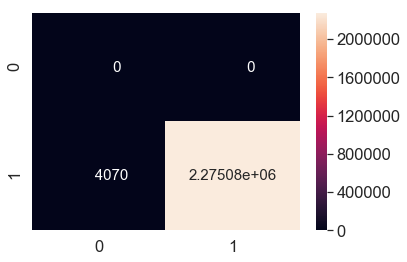

In [11]:
# only PURCHASE and CASH_OUT
MLData = data.copy()
MLData = MLData.loc[(MLData.PURCHASE + MLData.CASH_OUT) > 0]

MLData.drop(droplist, axis = 1,inplace = True)
X = MLData.drop('isFraud', axis = 1)
Y = MLData.isFraud
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 40, shuffle = False)

# LGBMClassifier
clf = lgb.LGBMClassifier(n_estimators = 100, max_depth = 2, n_jobs = 3, random_state = 40)
clf.fit(trainX, trainY)
presult(clf, testX, testY, 0)